## Sentiment Analysis: Yelp Restaurants Reviews

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range
import json

import os
from collections import Counter
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# import the garbage collection
import gc

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

#Set maximum number of rows,columns to be shown. Maximum column width made to 500.
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)

C:\Users\Mishraji\Miniconda3\envs\py3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\Mishraji\Miniconda3\envs\py3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
os.chdir("C:\Master\PD_Career\Courses\Springboard\Capstone Project 2")

#data directory
data_path = "yelp-datasets/"
intermediate_data_path = "yelp-datasets/intermediate/"
source_data_path = "yelp-datasets/source/"
submit_data_path = "yelp-datasets/submit/"

## Data Preview
First, We will preview the datasets by exploring how the data is stored in the source files. <br>.

In [3]:
with open(source_data_path+"yelp_academic_dataset_business.json", encoding='utf_8') as business_json_file:
    print(business_json_file.readline())

{"business_id":"1SWheh84yJXfytovILXOAQ","name":"Arizona Biltmore Golf Club","address":"2818 E Camino Acequia Drive","city":"Phoenix","state":"AZ","postal_code":"85016","latitude":33.5221425,"longitude":-112.0184807,"stars":3.0,"review_count":5,"is_open":0,"attributes":{"GoodForKids":"False"},"categories":"Golf, Active Life","hours":null}



In [4]:
with open(source_data_path+"yelp_academic_dataset_review.json", encoding='utf_8') as review_json_file:
    print(review_json_file.readline())

{"review_id":"Q1sbwvVQXV2734tPgoKj4Q","user_id":"hG7b0MtEbXx5QzbzE6C_VA","business_id":"ujmEBvifdJM6h6RLv4wQIg","stars":1.0,"useful":6,"funny":1,"cool":0,"text":"Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.","date":"2013-05-07 04:34:36"}



From the below two previews, it is evident that each row of the dataset is stored in json format. <br>
Let's look at a few business categories to check the types of establishments in yelp dataset. <br>
We will also be devising few categories for restaurants we would like to study further in the project. <br> 

In [5]:
# Preview few categories for the business json
with open(source_data_path+"yelp_academic_dataset_business.json", encoding='utf_8') as business_json_file:
    for line_no, business_json in enumerate(business_json_file):
        if line_no > 1000:
            break
        else:
            business_record = json.loads(business_json)
            print(business_record[u'categories'])

Golf, Active Life
Specialty Food, Restaurants, Dim Sum, Imported Food, Food, Chinese, Ethnic Food, Seafood
Sushi Bars, Restaurants, Japanese
Insurance, Financial Services
Plumbing, Shopping, Local Services, Home Services, Kitchen & Bath, Home & Garden, Water Heater Installation/Repair
Shipping Centers, Couriers & Delivery Services, Local Services, Printing Services
Beauty & Spas, Hair Salons
Hair Salons, Hair Stylists, Barbers, Men's Hair Salons, Cosmetics & Beauty Supply, Shopping, Beauty & Spas
Nail Salons, Beauty & Spas, Day Spas
Beauty & Spas, Nail Salons, Day Spas, Massage
Local Services, Professional Services, Computers, Shopping, Home Services, IT Services & Computer Repair, Internet Service Providers, Web Design
Restaurants, Breakfast & Brunch, Mexican, Tacos, Tex-Mex, Fast Food
Bars, Nightlife, Pubs, Barbers, Beauty & Spas, Irish Pub
Italian, Restaurants, Pizza, Chicken Wings
Bakeries, Food
Fitness & Instruction, Active Life, Yoga
Hair Stylists, Beauty & Spas, Hair Salons, Men

Waxing, Eyelash Service, Beauty & Spas, Hair Removal, Skin Care
Cocktail Bars, Italian, American (New), Nightlife, Bars, Pizza, Restaurants
Day Spas, Hair Salons, Beauty & Spas
Delis, Restaurants, Sandwiches, Pizza
Restaurants, Italian, Pizza
Post Offices, Notaries, Shipping Centers, Local Services, Mailbox Centers, Printing Services, Public Services & Government
Foundation Repair, Contractors, Waterproofing, Home Services
Education, Middle Schools & High Schools
Vietnamese, Restaurants
Food, Breakfast & Brunch, Ice Cream & Frozen Yogurt, Mexican, Cafes, Restaurants
Walking Tours, Tours, Hotels & Travel
Home Services, Professional Services, Real Estate, Real Estate Agents, Real Estate Services
Fruits & Veggies, Delis, Restaurants, Bakeries, Specialty Food, Farms, Arts & Entertainment, Food
Home Services, Mortgage Brokers, Real Estate
Hair Salons, Nail Salons, Beauty & Spas, Makeup Artists, Day Spas, Eyelash Service
Auto Repair, Car Dealers, Auto Detailing, Body Shops, Automotive
Tree S

<b>Analysis</b><br>
Based on sample 1000 categories, we notice that many establishments have multiple categories. <br>
The establishments with the folloiwng three categories seem to best match the restaurants: (1) Restaurants, (2) Bakeries, (3) Juice Bars
(4) Cafes. <br> 
Hence, we will gather reviews for all the establishments that are in at least one of above categories. 
All other reviews will be outside the scope of our project.<br>

<b>Prototype </b>
For the prototype, we will look for all restaurants within top 50000 business establishments.

In [10]:
restaurant_id_set = set()
with open(source_data_path+"yelp_academic_dataset_business.json", encoding='utf_8') as business_json_file:
    for line_no, business_json in enumerate(business_json_file):
        if line_no > 50000:
            break
        else:
            business_record = json.loads(business_json)
            
            #Check whether the business is a restaurant
            if business_record[u'categories'] is not None:
                if u'restaurants' in business_record[u'categories'].lower() \
                or u'bakeries' in business_record[u'categories'].lower() \
                or u'juice bars' in business_record[u'categories'].lower():
                    #print(business_record[u'categories'])
                    restaurant_id_set.add(business_record[u'business_id'])
                else:                    
                    continue            
                

In [12]:
print(len(restaurant_id_set))
restaurant_id_set = frozenset(restaurant_id_set)

15989


We will consider reviews of these 16000 establishments in restaurant category. <br>
The restaurant_id_set was converted to a frozenset so that it can't be accidentally modified. <br>

In [13]:
## Collect reviews for the restaurants in the set
## Data Preparation
if True:
    review_count=0
    
    # Write the reviews in text format. 
    with open(intermediate_data_path+"yelp_restaurants_review.txt", 'w' ,encoding='utf_8') as review_txt_file:
        with open(source_data_path+"yelp_academic_dataset_review.json", encoding='utf_8') as review_json_file:
            for line_no, review_json in enumerate(review_json_file):
                if line_no > 100000:
                    break
                else:
                    review_record=json.loads(review_json)

                    #Check if the review is about a restaurant
                    if review_record[u'business_id'] not in restaurant_id_set:
                        continue
                    #Write restaurant review as a line in the new file
                    #escape new line characters in the original review file
                    review_txt_file.write(review_record[u'text'].replace('\n', '\\n')+'\n')
                    review_count+=1
    print("Total number of reviews: ", review_count) 

Total number of reviews:  65052


In [14]:
gc.collect()

145

Now, we will load the first 5000 reviews for topic recognition

In [8]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r", encoding='utf_8') as fin:
        for line_no, line in enumerate(fin):
            if line_no >= 5000:
                break
            else:
                text = line.strip()
                text = text.replace('\\n', '\n')
                documents_list.append(text)          
    print("Total Number of Documents:",len(documents_list))
    return documents_list

In [9]:
document_list = load_data(intermediate_data_path,"yelp_restaurants_review.txt")

Total Number of Documents: 5000


In [13]:
document_list[0]

"Went in for a lunch. Steak sandwich was delicious, and the Caesar salad had an absolutely delicious dressing, with a perfect amount of dressing, and distributed perfectly across each leaf. I know I'm going on about the salad ... But it was perfect.\n\nDrink prices were pretty good.\n\nThe Server, Dawn, was friendly and accommodating. Very happy with her.\n\nIn summation, a great pub experience. Would go again!"

In [14]:
## Preprocess Data
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [15]:
clean_text=preprocess_data(document_list)

In [52]:
all_stemmed_tokens=[]
for i in range(len(clean_text)):
    for j in range(len(clean_text[i])):
        all_stemmed_tokens.append(clean_text[i][j])

## Finding the top 20 and bottom 20 words in the reviews

In [60]:
top_20_stemmed_tokens = Counter(all_stemmed_tokens).most_common(20)
print(top_20_stemmed_tokens)

[('food', 3716), ('place', 3074), ('good', 2998), ('order', 2383), ('great', 2233), ('time', 2034), ('like', 2016), ('servic', 1921), ('get', 1775), ('go', 1750), ('one', 1602), ('tri', 1476), ('back', 1446), ('realli', 1340), ('restaur', 1337), ('would', 1316), ('love', 1242), ('come', 1128), ('also', 1101), ('chicken', 1069)]


In [43]:
# Creating a function to find least common elements
from operator import itemgetter
import heapq
import collections
def least_common_values(array, to_find=None):
    counter = collections.Counter(array)
    if to_find is None:
        return sorted(counter.items(), key=itemgetter(1), reverse=False)
    return heapq.nsmallest(to_find, counter.items(), key=itemgetter(1))

In [44]:
least_common_values(all_stemmed_tokens,20)

[('tavolta', 1),
 ('outnumb', 1),
 ('romano', 1),
 ('gentler', 1),
 ('smdh', 1),
 ('92', 1),
 ('bside', 1),
 ('tika', 1),
 ('gnome', 1),
 ('smurf', 1),
 ('molotov', 1),
 ('poland', 1),
 ('hungarian', 1),
 ('pettuccin', 1),
 ('piccata', 1),
 ('raku', 1),
 ('gi', 1),
 ('whimp', 1),
 ('handheld', 1),
 ('vampir', 1)]

## Prepare Corpus and Dictionary of Terms

In [17]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

## Create LSA model using Gensim

In [18]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [19]:
## Determine the optimum number of topics
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [20]:
# Plot the coherence values
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

## LSA Model Building

In [21]:
# LSA Model
number_of_topics=7
words=10
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

[(0, '0.292*"food" + 0.237*"good" + 0.235*"order" + 0.230*"place" + 0.188*"like" + 0.172*"time" + 0.162*"get" + 0.148*"go" + 0.143*"one" + 0.134*"servic"'), (1, '0.514*"order" + -0.322*"good" + -0.307*"place" + -0.261*"great" + -0.254*"food" + 0.206*"us" + 0.143*"ask" + 0.137*"wait" + 0.133*"minut" + 0.132*"tabl"'), (2, '0.623*"food" + -0.238*"good" + -0.213*"like" + 0.209*"servic" + -0.177*"chicken" + -0.159*"sauc" + 0.141*"great" + 0.138*"us" + -0.116*"flavor" + -0.111*"order"'), (3, '-0.444*"food" + -0.428*"order" + 0.303*"place" + -0.277*"chicken" + -0.229*"good" + 0.218*"get" + 0.141*"go" + -0.121*"dish" + 0.113*"time" + -0.111*"sauc"'), (4, '-0.561*"place" + -0.434*"order" + 0.280*"restaur" + 0.181*"us" + -0.175*"time" + -0.159*"good" + 0.138*"menu" + 0.130*"tabl" + -0.123*"get" + 0.103*"great"'), (5, '-0.553*"good" + 0.489*"great" + 0.225*"order" + 0.181*"place" + 0.178*"chicken" + 0.171*"love" + -0.165*"like" + -0.143*"get" + 0.126*"fri" + 0.126*"delici"'), (6, '-0.512*"good" +

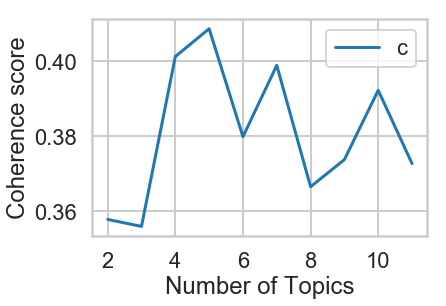

In [22]:
start,stop,step=2,12,1
plot_graph(clean_text,start,stop,step)

Now, we will build another model with 6 topics as shown by the coherence values.

In [23]:
# LSA Model
number_of_topics=5
words=10
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

[(0, '0.292*"food" + 0.237*"good" + 0.235*"order" + 0.230*"place" + 0.188*"like" + 0.172*"time" + 0.162*"get" + 0.148*"go" + 0.143*"one" + 0.134*"servic"'), (1, '-0.513*"order" + 0.321*"good" + 0.307*"place" + 0.261*"great" + 0.254*"food" + -0.206*"us" + -0.144*"ask" + -0.137*"wait" + -0.134*"minut" + -0.132*"tabl"'), (2, '0.623*"food" + -0.238*"good" + -0.213*"like" + 0.209*"servic" + -0.177*"chicken" + -0.160*"sauc" + 0.140*"great" + 0.139*"us" + -0.116*"flavor" + -0.111*"order"'), (3, '0.444*"food" + 0.428*"order" + -0.302*"place" + 0.277*"chicken" + 0.229*"good" + -0.217*"get" + -0.140*"go" + 0.121*"dish" + -0.112*"time" + 0.112*"sauc"'), (4, '-0.561*"place" + -0.432*"order" + 0.279*"restaur" + 0.184*"us" + -0.176*"time" + -0.163*"good" + 0.139*"menu" + 0.128*"tabl" + -0.124*"get" + 0.107*"great"')]


<b>Analysis</b> <br>
Based on above topic recognition, we identify 5 topics, however they were overlapping or unclear. <br>

As a next step, we will try lemmatization to check whether it returns better results. <br>
Lemmatization will make sure the lemmas are actual english words. <br>

## Lemmatization and LSA Model

In [45]:
import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [46]:
## Lemmatize Data
def lemmatize_set(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    # p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        lemmatized_tokens = [wordnet_lemmatizer.lemmatize(i, pos="v") for i in stopped_tokens]
        # add tokens to list
        texts.append(lemmatized_tokens)
    return texts

In [47]:
clean_lematized_text=lemmatize_set(document_list)

In [50]:
clean_lematized_text[0]

['go',
 'lunch',
 'steak',
 'sandwich',
 'delicious',
 'caesar',
 'salad',
 'absolutely',
 'delicious',
 'dress',
 'perfect',
 'amount',
 'dress',
 'distribute',
 'perfectly',
 'across',
 'leaf',
 'know',
 'go',
 'salad',
 'perfect',
 'drink',
 'price',
 'pretty',
 'good',
 'server',
 'dawn',
 'friendly',
 'accommodate',
 'happy',
 'summation',
 'great',
 'pub',
 'experience',
 'would',
 'go']

In [51]:
all_lemmatized_tokens=[]
for i in range(len(clean_lematized_text)):
    for j in range(len(clean_lematized_text[i])):
        all_lemmatized_tokens.append(clean_lematized_text[i][j])

## Finding the top 20 and bottom 20 lemmas from the reviews

In [56]:
top_20_lemmatized_tokens = Counter(all_lemmatized_tokens).most_common(20)
print(top_20_lemmatized_tokens)

[('food', 3669), ('place', 3074), ('good', 2950), ('get', 2836), ('go', 2514), ('order', 2383), ('great', 2229), ('time', 2020), ('come', 2006), ('like', 1986), ('service', 1921), ('one', 1508), ('try', 1472), ('make', 1450), ('back', 1446), ('really', 1340), ('would', 1316), ('love', 1167), ('also', 1101), ('eat', 1087)]


In [54]:
least_common_values(all_lemmatized_tokens,20)

[('tavolta', 1),
 ('outnumber', 1),
 ('romano', 1),
 ('gentler', 1),
 ('teen', 1),
 ('smdh', 1),
 ('92', 1),
 ('bside', 1),
 ('tika', 1),
 ('gnomes', 1),
 ('smurfs', 1),
 ('molotov', 1),
 ('poland', 1),
 ('hungarian', 1),
 ('softness', 1),
 ('internationally', 1),
 ('pettuccine', 1),
 ('piccata', 1),
 ('raku', 1),
 ('gi', 1)]

In [68]:
# Side by side comparison
print("{0:20}{1:20}{2:20}{3:20}".format("Stemming","Frequency","Lemmatization", "Frequency"))
for i in range(20):
    print("{0:20}{1:20}{2:20}{3:20}".format(top_20_stemmed_tokens[i][0], str(top_20_stemmed_tokens[i][1])
                                , top_20_lemmatized_tokens[i][0], str(top_20_lemmatized_tokens[i][1])))

Stemming            Frequency           Lemmatization       Frequency           
food                3716                food                3669                
place               3074                place               3074                
good                2998                good                2950                
order               2383                get                 2836                
great               2233                go                  2514                
time                2034                order               2383                
like                2016                great               2229                
servic              1921                time                2020                
get                 1775                come                2006                
go                  1750                like                1986                
one                 1602                service             1921                
tri                 1476    

In [69]:
print ('went' in all_lemmatized_tokens)

False


In [70]:
print ('went' in all_stemmed_tokens)

True


<b> Analysis </b> <br>
1. The lemmas are better readable compared with the stems. Example: servic vs service, tri vs try, realli vs really <br>
2. Lemmatization considered part of speech, Hence, it stores the main lemma associated with each words. Example: Frequency of lemma 'get' is higher than the stem 'get' because the lemma considers all words irrespective of part of speech.  <br>


## LSA Model

In [71]:
# LSA Model
number_of_topics=6
words=10
model=create_gensim_lsa_model(clean_lematized_text,number_of_topics,words)

[(0, '0.276*"food" + 0.261*"get" + 0.228*"order" + 0.223*"good" + 0.221*"place" + 0.211*"go" + 0.181*"come" + 0.178*"like" + 0.166*"time" + 0.130*"one"'), (1, '-0.407*"order" + 0.336*"good" + 0.301*"place" + 0.300*"food" + 0.272*"great" + -0.237*"get" + -0.190*"us" + -0.169*"take" + -0.167*"say" + -0.134*"ask"'), (2, '-0.651*"food" + 0.226*"like" + 0.224*"good" + -0.223*"service" + 0.174*"get" + -0.146*"us" + 0.144*"chicken" + -0.142*"great" + 0.138*"sauce" + -0.113*"come"'), (3, '0.525*"order" + -0.394*"get" + -0.280*"place" + -0.271*"go" + 0.268*"chicken" + 0.226*"food" + 0.169*"good" + 0.144*"sauce" + 0.144*"dish" + 0.128*"fry"'), (4, '0.482*"get" + 0.446*"good" + -0.325*"great" + 0.277*"food" + -0.161*"come" + 0.148*"order" + -0.148*"us" + -0.134*"menu" + -0.134*"restaurant" + -0.130*"make"'), (5, '0.547*"place" + 0.493*"order" + -0.262*"good" + 0.198*"great" + -0.184*"like" + 0.161*"time" + -0.155*"us" + -0.115*"would" + -0.114*"restaurant" + 0.111*"love"')]


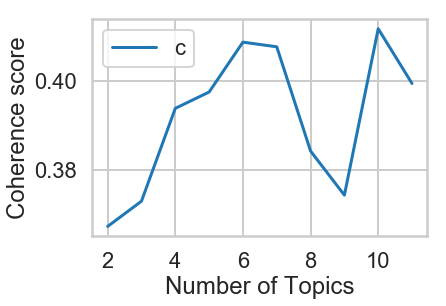

In [72]:
start,stop,step=2,12,1
plot_graph(clean_lematized_text,start,stop,step)

In [74]:
# LSA Model
number_of_topics=6
words=5
model=create_gensim_lsa_model(clean_lematized_text,number_of_topics,words)

[(0, '0.276*"food" + 0.261*"get" + 0.228*"order" + 0.223*"good" + 0.221*"place"'), (1, '-0.407*"order" + 0.336*"good" + 0.301*"place" + 0.299*"food" + 0.272*"great"'), (2, '-0.651*"food" + 0.225*"like" + 0.224*"good" + -0.224*"service" + 0.174*"get"'), (3, '0.525*"order" + -0.394*"get" + -0.280*"place" + -0.271*"go" + 0.267*"chicken"'), (4, '-0.482*"get" + -0.446*"good" + 0.324*"great" + -0.277*"food" + 0.161*"come"'), (5, '-0.546*"place" + -0.494*"order" + 0.264*"good" + -0.199*"great" + 0.183*"like"')]


## TF-IDF

In [76]:
dictionary_lemas, doc_term_matrix_lemas  = prepare_corpus(clean_lematized_text)

# Sample Format
# Dictionary(13918 unique tokens: ['absolutely', 'accommodate', 'across', 'amount', 'caesar']...)
# doc_term_matrix_lemas (word and how many documents it appears)
# [[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), 
# (12, 3), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), 
# (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)],

In [81]:
gc.collect()

2158

In [82]:
from gensim.models.tfidfmodel import TfidfModel
tfidf = TfidfModel(doc_term_matrix_lemas)

In [ ]:
tfidf_weights = tfidf[doc]